# Data processing

### Intro
This code will get the files with information of each stock and do following:
- Compute some technical indicators for each stock. Hence mfi, rsi, P/E and historical market cap
- Join all stocks together in a large datafile

In [4]:
import tqdm
import time
import os
import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [110]:
eod_path = Path.cwd()/"Eod" #path to create folder where end of day stock prices will be stored
fundamentals_path = Path.cwd()/"Fundamentals"
SingleStock_data = Path.cwd()/"SingleStock_data"

cwd = Path.cwd()

### Calculate RSI

In [7]:
#Method 1

#Convert to a temporary df
df = aapl.copy()
df["date"] =pd.to_datetime(df["date"])

#calculate daily price changes
delta = df['adjusted_close'].diff()

# Define the lookback period for RSI calculation
period = 14

# Calculate average gain and average loss
gain = delta.where(delta>0,0)
loss = -delta.where(delta<0,0)

# Calculate the average gain and average loss over the lookback period
avg_gain = gain.rolling(period).mean()
avg_loss = loss.rolling(period).mean()

# Calculate the relative strength (RS) and relative strength index (RSI)
rs = avg_gain/avg_loss
rsi = 100-(100/(1+rs))
df['RSI'] = rsi
df1=df[(df["date"]>'2022-06-01')&(df["date"]<'2023-06-03')]
df1

,date,open,high,low,close,adjusted_close,volume,index,currency,epsActual,epsEstimate,epsDifference,surprisePercent,outstandingShares,RSI
39,2023-06-02,181.03,181.78,179.26,180.95,180.7060,61945900,394,USD,1.52,1.43,0.09,6.2937,1.584705e+10,33.967646
40,2023-06-01,177.70,180.12,176.93,180.09,179.8471,68901800,395,USD,1.52,1.43,0.09,6.2937,1.584705e+10,31.233309
41,2023-05-31,177.33,179.35,176.76,177.25,177.0110,99625300,396,USD,1.52,1.43,0.09,6.2937,1.584705e+10,31.576458
42,2023-05-30,176.96,178.99,176.57,177.30,177.0609,55964400,397,USD,1.52,1.43,0.09,6.2937,1.584705e+10,27.600512
43,2023-05-26,173.32,175.77,173.11,175.43,175.1934,54835000,401,USD,1.52,1.43,0.09,6.2937,1.584705e+10,25.013446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2022-06-08,148.58,149.87,147.46,147.96,146.8834,53950200,753,USD,1.52,1.43,0.09,6.2937,1.651929e+10,59.999954
287,2022-06-07,144.35,149.00,144.10,148.71,147.6279,67808200,754,USD,1.52,1.43,0.09,6.2937,1.651929e+10,63.224524
288,2022-06-06,147.03,148.57,144.90,146.14,145.0766,71598400,755,USD,1.52,1.43,0.09,6.2937,1.651929e+10,55.468715
289,2022-06-03,146.90,147.97,144.46,145.38,144.3222,88570300,758,USD,1.52,1.43,0.09,6.2937,1.651929e+10,54.458357


In [8]:
#Method 2

df = aapl.copy()
df["date"] =pd.to_datetime(df["date"])
def rsi(df, periods = 14):
    
    delta = df['adjusted_close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

df['RSI'] = rsi(df)
df1=df[(df["date"]>'2022-06-01')&(df["date"]<'2023-06-03')]
df

,date,open,high,low,close,adjusted_close,volume,index,currency,epsActual,epsEstimate,epsDifference,surprisePercent,outstandingShares,RSI
0,2023-07-31,196.06,196.49,195.26,196.45,196.1851,38824100,335,USD,1.26,1.19,0.07,5.8824,NaN,NaN
1,2023-07-28,194.67,196.63,194.14,195.83,195.5659,48291400,338,USD,1.26,1.19,0.07,5.8824,NaN,NaN
2,2023-07-27,196.02,197.20,192.55,193.22,192.9594,47460200,339,USD,1.26,1.19,0.07,5.8824,NaN,NaN
3,2023-07-26,193.67,195.64,193.32,194.50,194.2377,47471900,340,USD,1.26,1.19,0.07,5.8824,NaN,NaN
4,2023-07-25,193.33,194.44,192.92,193.62,193.3589,37283200,341,USD,1.26,1.19,0.07,5.8824,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,2022-01-07,172.89,174.14,171.03,172.17,170.4493,86709100,905,USD,2.10,1.89,0.21,11.1111,1.651929e+10,55.046687
391,2022-01-06,172.70,175.30,171.64,172.00,170.2810,96904000,906,USD,2.10,1.89,0.21,11.1111,1.651929e+10,54.717441
392,2022-01-05,179.61,180.17,174.64,174.92,173.1718,94537600,907,USD,2.10,1.89,0.21,11.1111,1.651929e+10,59.228363
393,2022-01-04,182.63,182.94,179.12,179.70,177.9041,99310400,908,USD,2.10,1.89,0.21,11.1111,1.651929e+10,65.319026


### Calculate MFI

In [9]:
df = amzn.copy()
df["date"] =pd.to_datetime(df["date"])

#First to functions to compute gains and losses will be needed
def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(df, n=14):
    high = df["high"]
    low = df["low"]
    close = df["adjusted_close"]
    volume = df["volume"]
    
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    
    return mfi

df["MFI"] = mfi(df)
df1=df[(df["date"]>'2022-06-01')&(df["date"]<'2023-06-03')]
df1


,date,open,high,low,close,adjusted_close,volume,index,currency,epsActual,epsEstimate,epsDifference,surprisePercent,outstandingShares,MFI
39,2023-06-02,124.920,126.39,124.020,124.25,124.250,61215000,394,USD,0.31,0.21,0.10,47.6190,1.025800e+10,41.798023
40,2023-06-01,120.690,123.49,119.930,122.77,122.770,54375100,395,USD,0.31,0.21,0.10,47.6190,1.025800e+10,43.811795
41,2023-05-31,121.450,122.04,119.170,120.58,120.580,72800800,396,USD,0.31,0.21,0.10,47.6190,1.025800e+10,42.875775
42,2023-05-30,122.370,122.92,119.860,121.66,121.660,64314800,397,USD,0.31,0.21,0.10,47.6190,1.025800e+10,43.224679
43,2023-05-26,116.040,121.50,116.020,120.11,120.110,96681000,401,USD,0.31,0.21,0.10,47.6190,1.025800e+10,32.940028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2022-06-08,122.610,123.75,120.750,121.18,121.180,64926594,753,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,58.967376
287,2022-06-07,122.005,124.10,120.630,123.00,123.000,85156711,754,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,59.727554
288,2022-06-06,125.245,128.99,123.810,124.79,124.790,135268984,755,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,62.844326
289,2022-06-03,2484.000,2488.00,2420.929,2447.00,122.350,97603319,758,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,83.237063


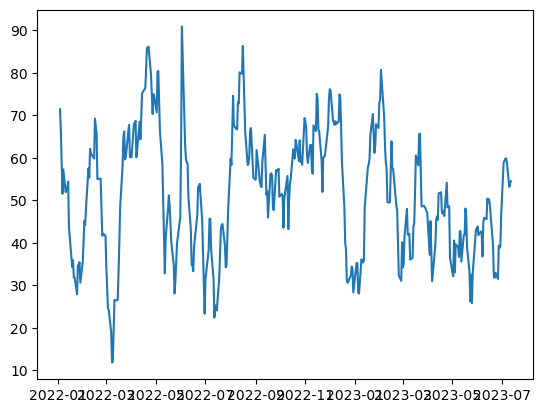

In [10]:
plt.plot(df["date"],df["MFI"])

### Calculate volatility

In [11]:
df = amzn.copy()
df["date"] =pd.to_datetime(df["date"])

def vol(df, period = 21):
    daily_return = df['adjusted_close'].pct_change()
    
    volatility = daily_return.rolling(window = period).std()
    
    return volatility

df["volatility"]=vol(df)
df1=df[(df["date"]>'2022-06-01')&(df["date"]<'2023-06-03')]
df1

,date,open,high,low,close,adjusted_close,volume,index,currency,epsActual,epsEstimate,epsDifference,surprisePercent,outstandingShares,volatility
39,2023-06-02,124.920,126.39,124.020,124.25,124.250,61215000,394,USD,0.31,0.21,0.10,47.6190,1.025800e+10,0.017559
40,2023-06-01,120.690,123.49,119.930,122.77,122.770,54375100,395,USD,0.31,0.21,0.10,47.6190,1.025800e+10,0.017685
41,2023-05-31,121.450,122.04,119.170,120.58,120.580,72800800,396,USD,0.31,0.21,0.10,47.6190,1.025800e+10,0.017965
42,2023-05-30,122.370,122.92,119.860,121.66,121.660,64314800,397,USD,0.31,0.21,0.10,47.6190,1.025800e+10,0.017805
43,2023-05-26,116.040,121.50,116.020,120.11,120.110,96681000,401,USD,0.31,0.21,0.10,47.6190,1.025800e+10,0.017754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2022-06-08,122.610,123.75,120.750,121.18,121.180,64926594,753,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,0.034638
287,2022-06-07,122.005,124.10,120.630,123.00,123.000,85156711,754,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,0.034075
288,2022-06-06,125.245,128.99,123.810,124.79,124.790,135268984,755,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,0.034154
289,2022-06-03,2484.000,2488.00,2420.929,2447.00,122.350,97603319,758,USD,0.37,0.42,-0.05,-11.9048,1.018000e+10,0.034231


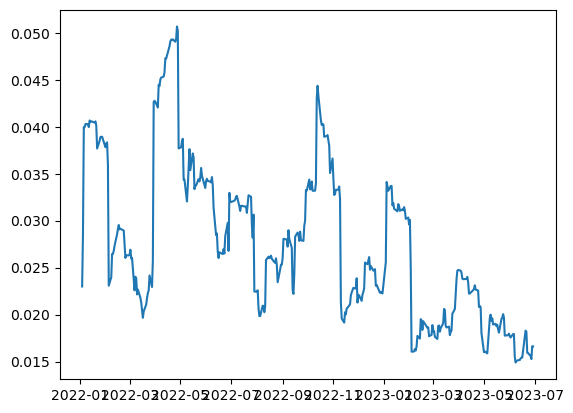

In [12]:
plt.plot(df["date"],df["volatility"])

In [97]:
def rsi(df, periods = 14):
    
    delta = df['adjusted_close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

def gain(x):
    return ((x > 0) * x).sum()


def loss(x):
    return ((x < 0) * x).sum()


def mfi(df, n=14):
    high = df["high"]
    low = df["low"]
    close = df["adjusted_close"]
    volume = df["volume"]
    
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    
    mfi = (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()
    
    return mfi

def vol(df, period = 21):
    daily_return = df['adjusted_close'].pct_change()
    
    volatility = daily_return.rolling(window = period).std()
    
    return volatility

def compute_technical(df):
    df["date"] =pd.to_datetime(df["date"])
    #compute RSI
    df['RSI'] = rsi(df)
    
    #compute MFI
    df["MFI"] = mfi(df)
    
    #compute volatility
    df["volatility"]=vol(df)
    
    return df
    
    

## Create master dataframe:
Time to join all dataframes into one

In [98]:
def compute_data(df):
    
    df["date"] = pd.to_datetime(df["date"])
    df = compute_technical(df)
    df = df.drop('close',axis =1)
    df["returns"] = (df["adjusted_close"]-df["adjusted_close"].shift(-1))/df["adjusted_close"].shift(-1)*100
    df['prev_returns'] = df['returns'].shift(-1)
    df['returns_pred'] = df['returns'].shift(1)
    df = df[(df["date"]>='2022-06-01')&(df["date"]<='2023-06-02')]
    
    return df

def master_df(master, df, ticker):
    """
    Finds data for a single stocks and joins it to masterdataframe on=date how=left
    
    Args(pandas.DataFrame): dataframe of the company that will be joined to the master dataframe
                            the existing master dataframe
    Args(str): ticker of the company that will be joined to master dataframe
    
    returns the updated master dataframe
    """

    df["date"] = pd.to_datetime(df["date"])
    df["Ticker"] = ticker

    master = pd.concat([master,df])
    master["date"] = pd.to_datetime(master["date"])
    master = master.sort_values(["date", "Ticker"], ascending=[False, True]).reset_index(drop = True)
    
    return master


def compute_fundamentals(df):
    df["date"] = pd.to_datetime(df["date"])
    df["marketcap"] = df["adjusted_close"]*df["outstandingShares"]
    df["PE"] = df["adjusted_close"]/df["epsActual"]
    #RSI missing
    #MFI missing
    #Standard deviation missing
    
    return df

In [111]:
#get tickers for stocks
tickers = pd.read_csv("Tickers_final.csv")["Ticker"].values
tickers = pd.read_csv("tickers_list_news.csv")['0'].values
tickers

array(['AAPL', 'MSFT', 'GOOG', ..., 'CURI', 'NSTS', 'STIM'], dtype=object)

### Master dataframe for EoD only

In [112]:
#delete this sentence # delete this if you want to rund the code - its just a fail safe


master_eod = pd.DataFrame() #define empty dataframe. THis is the final dataframe
for ticker in tqdm.tqdm(tickers):
    #get datafram from csv
    df = pd.read_csv(eod_path/f"{ticker}.csv")
    master_eod = master_df(master_eod,df,ticker)
    master_eod.to_csv("Master_eod.csv", index = False)
    

 28%|██▊       | 539/1956 [25:44<1:07:39,  2.86s/it]


OSError: [Errno 22] Invalid argument

In [168]:
master_eod = master_eod.sort_values("date", ascending=False)

In [45]:
mast = pd.read_csv("Master_eod.csv").drop("Unnamed: 0", axis =1)
mast["date"]=pd.to_datetime(mast["date"])
mast.sort_values(['date', 'Ticker'], ascending=[False,True])

,date,open,high,low,close,adjusted_close,volume,Ticker
421640,2023-06-02,8.01,8.0900,7.87,8.0600,8.0600,74700,AADI
53848,2023-06-02,14.90,15.0700,14.64,14.8700,14.8700,31041300,AAL
296164,2023-06-02,2.21,2.2700,2.16,2.2700,2.2700,148200,AAOI
79756,2023-06-02,88.82,91.6800,88.73,91.5800,91.5033,243389,AAON
0,2023-06-02,181.03,181.7800,179.26,180.9500,180.7060,61945900,AAPL
...,...,...,...,...,...,...,...,...
324103,2022-05-31,33.51,33.5100,32.30,32.8100,32.8100,418900,ZUMZ
398525,2022-05-31,4.72,4.8000,4.58,4.6300,4.6300,355672,ZVRA
290067,2022-05-31,6.89,7.0300,6.60,6.7200,6.7200,3481600,ZYME
484377,2022-05-31,1.02,1.0200,0.94,0.9575,0.9575,218994,ZYNE


### Master dataframe with technicals, returns and taget returns

In [305]:
tickers = pd.read_csv("tickers_list_news.csv")['0'].values
len(tickers)

1956

In [309]:
delete this sentence # delete this sentence if you are sure you want to run this code

master_tech = pd.DataFrame() #define empty dataframe. THis is the final dataframe

for ticker in tqdm.tqdm(tickers):
    #get datafram from csv
    df = pd.read_csv(eod_path/f"{ticker}.csv")
    df = compute_data(df)
    master_tech = master_df(master_tech, df, ticker)
    master_tech.to_csv("Master_with_technicals_news.csv", index = False)

100%|██████████| 1956/1956 [1:34:11<00:00,  2.89s/it]


In [19]:
master_tech = pd.read_csv("Master_with_technicals_news.csv")
master_tech = master_tech.sort_values(["date","Ticker"], ascending = [False,True])

In [21]:
master_tech

,date,open,high,low,adjusted_close,volume,RSI,MFI,volatility,returns,prev_returns,returns_pred,Ticker
0,2023-06-02,8.01,8.0900,7.8700,8.0600,74700,66.502362,48.430352,0.029908,2.025316,-1.250000,0.868486,AADI
1,2023-06-02,14.90,15.0700,14.6400,14.8700,31041300,23.119364,35.726831,0.014020,1.156463,-0.541272,-0.403497,AAL
2,2023-06-02,2.21,2.2700,2.1600,2.2700,148200,26.678504,47.236530,0.089979,2.714932,-0.450450,2.643172,AAOI
3,2023-06-02,88.82,91.6800,88.7300,91.5033,243389,36.479318,50.327996,0.016983,4.459876,1.223862,-0.458563,AAON
4,2023-06-02,181.03,181.7800,179.2600,180.7060,61945900,36.976220,45.237000,0.009638,0.477572,1.602217,-0.757141,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
494863,2022-06-01,33.26,33.3400,32.2600,32.9700,557900,68.832023,57.020542,0.033060,0.487656,-3.300914,3.639672,ZUMZ
494864,2022-06-01,4.64,4.7050,4.4900,4.5700,257036,45.655482,44.451853,0.035933,-1.295896,-1.279318,3.501094,ZVRA
494865,2022-06-01,6.85,7.1100,6.6450,6.9800,996500,59.232450,56.263023,0.052836,3.869048,-2.183406,-3.295129,ZYME
494866,2022-06-01,0.97,0.9899,0.9021,0.9050,237207,39.897928,87.930630,0.087510,-5.483029,-1.875384,7.182320,ZYNE


In [106]:
# Find the location of NaN values
nan_locations = np.where(pd.isnull(master_tech))

# The 'nan_locations' tuple contains two arrays: one for row indices and one for column indices
row_loc, cols_loc = nan_locations

# after analysing NaN values we notice that the missings values for MFI column are simply 0
# The calculation returns NaN when the high or low price is the same for more than 14 days
#as the average becomes 0 and we end up dividing by zero. Therefore, all NaN in MFI column are filled by zero

master_tech["MFI"].fillna(0, inplace = True)
master_tech["volatility"].fillna(method = 'bfill', inplace = True)
master_tech.to_csv("Master_with_technicals_news.csv", index = False)